# Dataset

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def labels(data):
    label1 = np.where(data == 0.0,1.0,0.0)
    label2 = np.where(data == 1.0,1.0,0.0)
    mask = np.dstack((label1, label2))
    return mask

class Jetfire_Dataset(Dataset):
    def __init__(self, data, masks, new_height, new_width):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        self.new_height = new_height
        self.new_width = new_width
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
        
    def __len__(self):
        
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks)
        return len(self.images)
        
    
    def __getitem__(self,idx):
        
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        img = img.convert('RGB')
        resize = T.Resize((self.new_height, self.new_width))
        img = resize(img)
        trans = T.ToTensor()
        img = trans(img)
        mask_name = os.path.join(self.train_masks, self.masks[idx])
        mask = Image.open(mask_name)
        mask = resize(mask)
        mask = np.array(mask)
        mask = labels(mask)
        mask = trans(mask)
        mask_max = mask.max().item() #
        mask /= mask_max #
        
        return img,mask

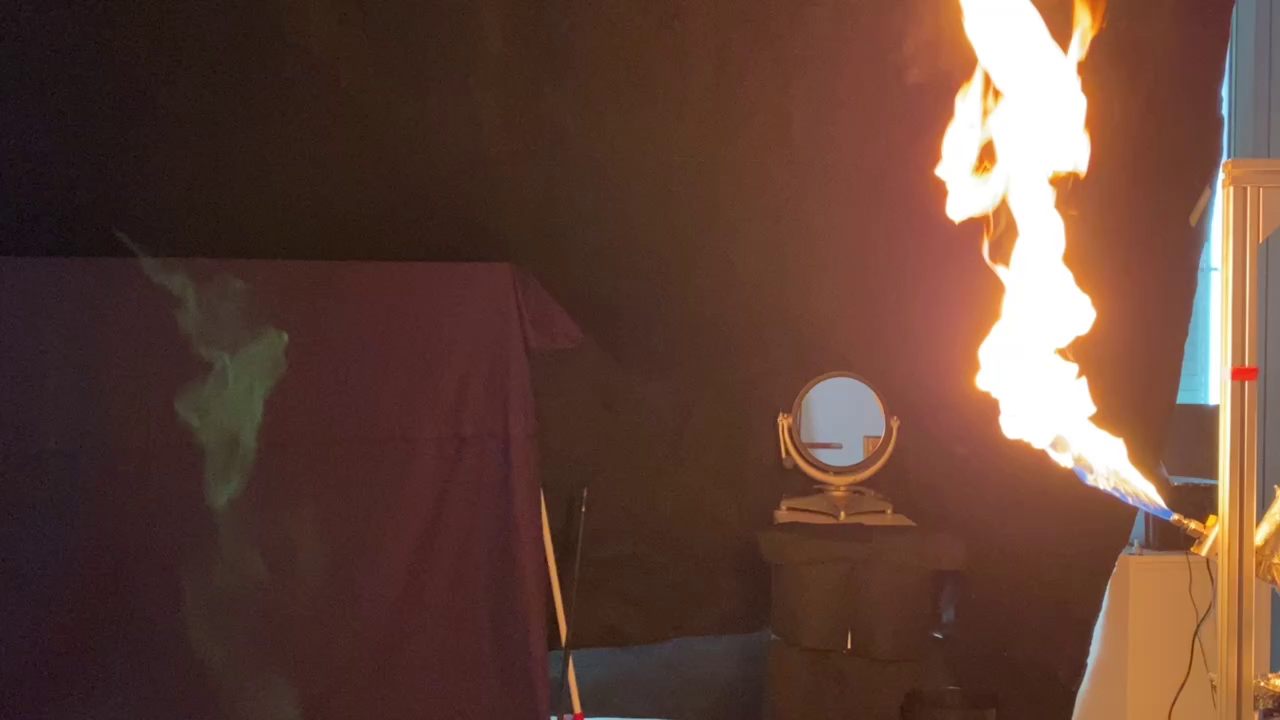

In [3]:
example_img = Image.open('Visible_match/frame_0.png')
example_img

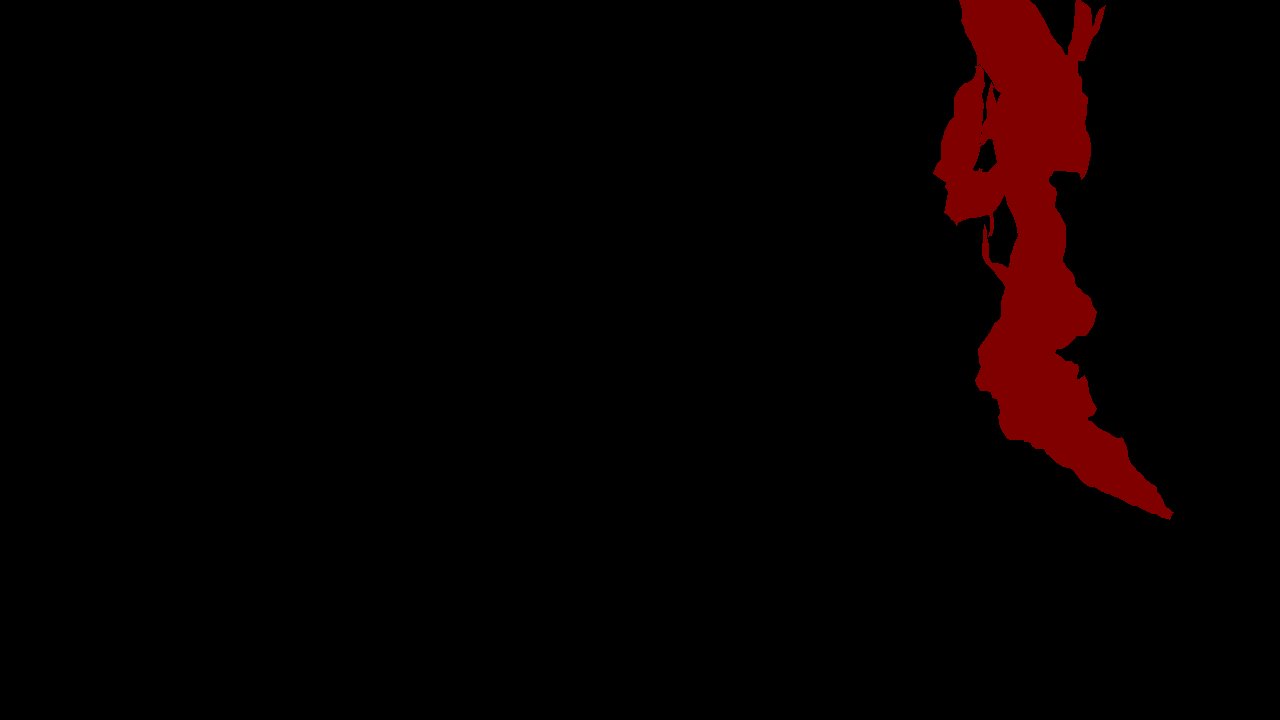

In [4]:
example_mask = Image.open('SegmentationClass/frame_0.png')
example_mask

Full size 104
Train size:  66
Test size:  21
Val size:  17


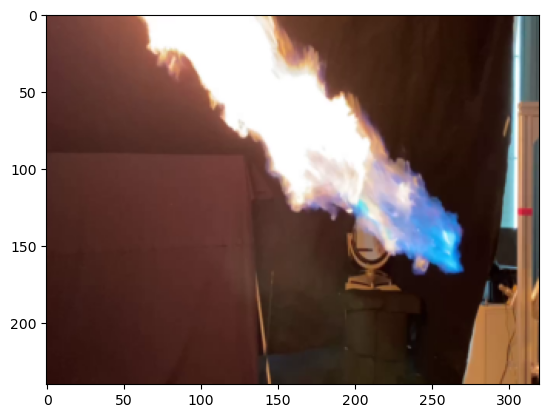

In [5]:
IMG_DIR = r"C:\Users\egard\Desktop\Github\Visible_match"
MASK_DIR = r"C:\Users\egard\Desktop\Github\SegmentationClass"

full_dataset = Jetfire_Dataset(IMG_DIR,
                              MASK_DIR,
                              240,
                              320)

batch_size = 10
torch.manual_seed(77)

train_size = int(len(full_dataset)*0.8)
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_size = int(len(train_dataset)*0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

print('Full size', len(full_dataset))
print('Train size: ', len(train_dataset))
print('Test size: ', len(test_dataset))
print('Val size: ', len(val_dataset))

imgs, masks = next(iter(train_loader))

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(imgs[7]))

# Deep Learning Model

## Small UNET

In [6]:
import torch.nn as nn

class Conv_3_k(nn.Module):
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 1, padding = 1)
    def forward(self,x):
        return self.conv1(x)

class Double_Conv(nn.Module):
    '''
    Double Convolution
    '''
    
    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                            Conv_3_k(channels_in,channels_out),
                            nn.BatchNorm2d(channels_out),
                            nn.ReLU(),
                            Conv_3_k(channels_out,channels_out),
                            nn.BatchNorm2d(channels_out),
                            nn.ReLU(),
                            )
    def forward(self,x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in,channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)

class Up_Conv(nn.Module):
    '''
    Up convolution
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor = 2, mode = "nearest"),
                        nn.Conv2d(channels_in, channels_in-channels_out, kernel_size = 1 , stride = 1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
        
    def forward(self,x1,x2):
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2,x1],dim = 1)
        return self.decoder(x)

class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels)
        self.down_conv1 = Down_Conv(channels, 2*channels)
        self.down_conv2 = Down_Conv(2*channels, 3*channels)
        self.down_conv3 = Down_Conv(3*channels, 4*channels)
        
        self.middle_conv = Down_Conv(4*channels, 5*channels)
        
        self.up_conv1 = Up_Conv(5*channels, 4*channels)
        self.up_conv2 = Up_Conv(4*channels, 3*channels)
        self.up_conv3 = Up_Conv(3*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size = 1, stride = 1)
        
    def forward(self,x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5,x4)
        u2 = self.up_conv2(u1,x3)
        u3 = self.up_conv3(u2,x2)
        u4 = self.up_conv4(u3,x1)
        
        return self.last_conv(u4)

# Training

In [7]:
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import warnings
import sys
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
torch.cuda.empty_cache()

In [8]:
def IOU_metric(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def F1_metric(y_true, y_pred):
    true_positive = np.sum(np.logical_and(y_true, y_pred))
    false_positive = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
    false_negative = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))

    precision = true_positive / (true_positive + false_positive + 1e-10)
    recall = true_positive / (true_positive + false_negative + 1e-10)

    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1_score

In [9]:
def label_img_to_color(img):
    label_to_color = {
        0: [0,  0,  0],
        1: [128, 0, 0],
        }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col]

            img_color[row, col] = np.array(label_to_color[label])

    return img_color

In [10]:
def train(model, loss_fn, lr, epochs, train_data, val_data, test_data):
    optimizer = optim.Adam(model.parameters(), lr =  lr)
    scaler  = torch.cuda.amp.GradScaler()
    lst_loss = []
    lst_f1 = []
    mean_loss = 0
    mean_f1 = 0
    lst_mean_loss = []
    lst_mean_f1 = []
    val_lst_loss = []
    val_lst_f1 = []
    val_mean_loss = 0
    val_mean_f1 = 0
    val_lst_mean_loss = []
    val_lst_mean_f1 = []
    test_lst_loss = []
    test_lst_f1 = []
    test_mean_loss = 0
    test_mean_f1 = 0
    test_lst_mean_loss = []
    test_lst_mean_f1 = []
    
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        loop = tqdm(train_data)
        for mb, (x_input, y_output) in enumerate(loop, start = 1):
            model.train()
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).squeeze(1)
            with torch.cuda.amp.autocast():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
        
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            loop.set_postfix(loss_function = loss.item())
            
        model.eval()
        lst_lost = []
        lst_f1 = []
        for i, data in enumerate(train_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).squeeze(1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                f1 = F1_metric(y_output, prediction)
                lst_f1.append(f1)
        
        mean_loss = np.mean(lst_loss)
        lst_mean_loss.append(mean_loss)
        mean_f1 = np.mean(lst_f1)
        lst_mean_f1.append(mean_f1)
        
        val_lst_lost = []
        val_lst_f1 = []
        for i, data in enumerate(val_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).squeeze(1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                val_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                f1 = F1_metric(y_output, prediction)
                val_lst_f1.append(f1)
        
        val_mean_loss = np.mean(val_lst_loss)
        val_lst_mean_loss.append(val_mean_loss)
        val_mean_f1 = np.mean(val_lst_f1)
        val_lst_mean_f1.append(val_mean_f1)
        
        test_lst_lost = []
        test_lst_f1 = []
        for i, data in enumerate(test_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device).squeeze(1)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                test_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                f1 = F1_metric(y_output, prediction)
                test_lst_f1.append(f1)
        
        test_mean_loss = np.mean(test_lst_loss)
        test_lst_mean_loss.append(test_mean_loss)
        test_mean_f1 = np.mean(test_lst_f1)
        test_lst_mean_f1.append(test_mean_f1)

    ax = sns.lineplot(x = range(len(lst_mean_loss)), y = lst_mean_loss, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss)), y = val_lst_mean_loss, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss)), y = test_lst_mean_loss, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_f1)), y = lst_mean_f1, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_f1)), y = val_lst_mean_f1, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_f1)), y = test_lst_mean_f1, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss: ", lst_mean_loss[-1])
    print("Validation Loss: ", val_lst_mean_loss[-1])
    print("Test Loss", test_lst_mean_loss[-1])
    print("Train F1 score: ", lst_mean_f1[-1])
    print("Validation F1 score: ", val_lst_mean_f1[-1])
    print("Test F1 score", test_lst_mean_f1[-1])
    
    
    return model, lst_mean_loss[-1], val_lst_mean_loss[-1], test_lst_mean_loss[-1], lst_mean_f1[-1], val_lst_mean_f1[-1], test_lst_mean_f1[-1]

Epoch:  1


100%|███████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.65it/s, loss_function=0.379]


Epoch:  2


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.311]


Epoch:  3


100%|████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s, loss_function=0.31]


Epoch:  4


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s, loss_function=0.3]


Epoch:  5


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s, loss_function=0.263]


Epoch:  6


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s, loss_function=0.245]


Epoch:  7


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s, loss_function=0.241]


Epoch:  8


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s, loss_function=0.249]


Epoch:  9


100%|████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s, loss_function=0.24]


Epoch:  10


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.221]


Epoch:  11


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s, loss_function=0.216]


Epoch:  12


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s, loss_function=0.2]


Epoch:  13


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s, loss_function=0.199]


Epoch:  14


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s, loss_function=0.215]


Epoch:  15


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.78it/s, loss_function=0.195]


Epoch:  16


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.179]


Epoch:  17


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s, loss_function=0.184]


Epoch:  18


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s, loss_function=0.184]


Epoch:  19


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.78it/s, loss_function=0.165]


Epoch:  20


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.76it/s, loss_function=0.165]


Epoch:  21


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s, loss_function=0.157]


Epoch:  22


100%|████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s, loss_function=0.15]


Epoch:  23


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s, loss_function=0.147]


Epoch:  24


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s, loss_function=0.168]


Epoch:  25


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s, loss_function=0.147]


Epoch:  26


100%|███████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.71it/s, loss_function=0.147]


Epoch:  27


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s, loss_function=0.136]


Epoch:  28


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.77it/s, loss_function=0.135]


Epoch:  29


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.75it/s, loss_function=0.141]


Epoch:  30


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s, loss_function=0.124]


Epoch:  31


100%|████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s, loss_function=0.12]


Epoch:  32


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.117]


Epoch:  33


100%|████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s, loss_function=0.13]


Epoch:  34


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s, loss_function=0.116]


Epoch:  35


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s, loss_function=0.112]


Epoch:  36


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.119]


Epoch:  37


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s, loss_function=0.104]


Epoch:  38


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s, loss_function=0.113]


Epoch:  39


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.113]


Epoch:  40


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s, loss_function=0.107]


Epoch:  41


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.105]


Epoch:  42


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s, loss_function=0.0964]


Epoch:  43


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s, loss_function=0.104]


Epoch:  44


100%|███████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.77it/s, loss_function=0.113]


Epoch:  45


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s, loss_function=0.0982]


Epoch:  46


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s, loss_function=0.0917]


Epoch:  47


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s, loss_function=0.0928]


Epoch:  48


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s, loss_function=0.0971]


Epoch:  49


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.78it/s, loss_function=0.0961]


Epoch:  50


100%|██████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s, loss_function=0.0815]


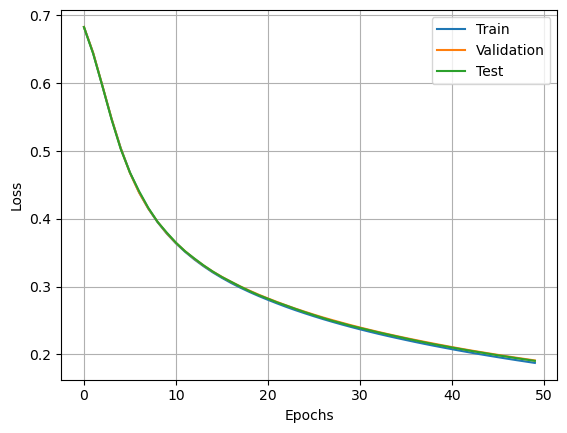

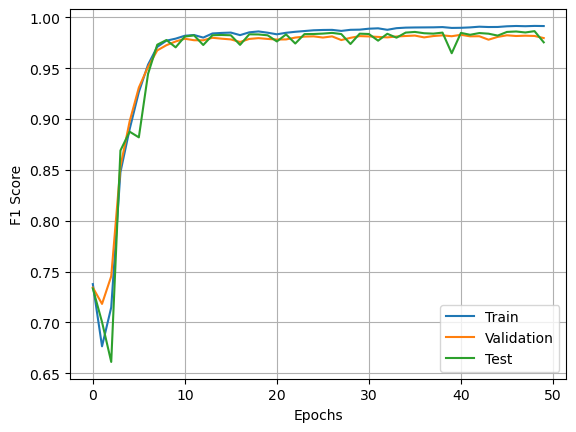

Train Loss:  0.18753116668647607
Validation Loss:  0.1911891410114165
Test Loss 0.19056821825158227
Train F1 score:  0.9914117109138099
Validation F1 score:  0.9795859618691064
Test F1 score 0.9754005370749582


In [11]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = train(UNET(channels_in = 3 , channels = 64 , num_classes = 2).to(device), loss_fn, lr, epochs, train_loader, val_loader, test_loader)

# Save result images

In [12]:
def save_img(infrared, mask, prediction, i, IOU, F1, name):
    list_title = ["Visible", "Mask", "Prediction\n" + "IOU: " + str(round(IOU, 3)) + "\nF1: " + str(round(F1, 3))]
    imgs = [infrared, mask, prediction]
    widths, heights = zip(*(i.size for i in imgs))
    
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in imgs:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    draw = ImageDraw.Draw(new_im)
    font = ImageFont.truetype("arial.ttf", 32)
    x_text = 0
    x = 0
    
    for title in list_title:
        w, h = draw.textsize(title, font=font)
        
        x_center = (widths[x_text] - w) / 2
        draw.text((x + x_center - 1, max_height - h - 10), title, (0,0,0), font=font)
        draw.text((x + x_center + 1, max_height - h - 10), title, (0,0,0), font=font)
        draw.text((x + x_center, max_height - h - 11), title, (0,0,0), font=font)
        draw.text((x + x_center, max_height - h - 9), title, (0,0,0), font=font)
        draw.text((x + x_center, max_height - h - 10), title, (255,255,255), font=font)
        
        x += widths[x_text]
        x_text += 1
        
    new_im.save(name)

## Train

In [13]:
from PIL import Image, ImageDraw, ImageFont
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)
IOU_lst = []
F1_lst = []
best_IOU = 0
best_F1 = 0
worst_IOU = 100
worst_F1 = 100
i = 0
unet_model.eval()
for imgs_train, masks_train in train_loader:
    for j in range(len(imgs_train)):
        imgs_train = imgs_train.to(device, dtype = torch.float32)
        with torch.no_grad():
            prediction = unet_model(imgs_train)
            y = masks_train.to(device = device, dtype = torch.float32).squeeze(1)
        
            prediction = torch.argmax(prediction, dim = 1).float()
            prediction = prediction.cpu()
            prediction = prediction.numpy()
            prediction = label_img_to_color(prediction[j])
            prediction = Image.fromarray(prediction.astype(np.uint8), 'RGB')
        
            y = torch.argmax(y, dim = 1).float()
            y = y.cpu()
            y = y.numpy()
            y = label_img_to_color(y[j])
            y = Image.fromarray(y.astype(np.uint8), 'RGB')
        
        
            IOU = IOU_metric(prediction, y)
            F1 = F1_metric(prediction, y)
        
            IOU_lst.append(IOU)
            F1_lst.append(F1)
        
            imgs_train = imgs_train.cpu()
            img_array = imgs_train[j].permute(1,2,0).numpy()*255
            img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
        
            i+=1
            name = "Train_jetfire/Img"+str(i)+".png"
            save_img(img, y, prediction, i, IOU, F1, name)
            
            prediction.save("Train/Result Mask/Img"+str(i)+".png")
            y.save("Train/Ground Truth/Img"+str(i)+".png")
            img.save("Train/Visible/Img"+str(i)+".png")
        
            if IOU > best_IOU:
                best_IOU = IOU
                save_img(img, y, prediction, i, IOU, F1, "Train_jetfire/Best_IOU.png")
            
            if F1 > best_F1:
                best_F1 = F1
                save_img(img, y, prediction, i, IOU, F1, "Train_jetfire/Best_F1.png")
        
            if IOU < worst_IOU:
                worst_IOU = IOU
                save_img(img, y, prediction, i, IOU, F1, "Train_jetfire/Worst_IOU.png")
            
            if F1 < worst_F1:
                worst_F1 = F1
                save_img(img, y, prediction, i, IOU, F1, "Train_jetfire/Worst_F1.png")

                
print("Mean IOU: " + str(np.mean(IOU_lst)))
print("Best IOU: " + str(best_IOU))
print("Worst IOU: " + str(worst_IOU))


print("Mean F1: " + str(np.mean(F1_lst)))
print("Best F1: " + str(best_F1))
print("Worst F1: " + str(worst_F1))

Mean IOU: 0.9804145863697966
Best IOU: 0.9911457293122962
Worst IOU: 0.948898478310243
Mean F1: 0.9900890685035596
Best F1: 0.9955531779231785
Worst F1: 0.973779279754211


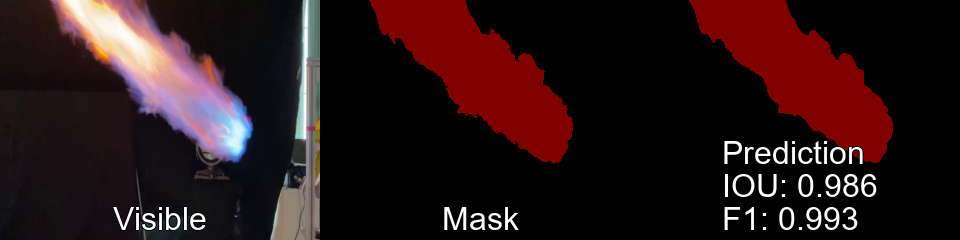

In [14]:
example_train = Image.open('Train_jetfire/Img1.png')
example_train

## Test

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)
IOU_lst = []
F1_lst = []
best_IOU = 0
best_F1 = 0
worst_IOU = 100
worst_F1 = 100
i = 0
unet_model.eval()
for imgs_test, masks_test in test_loader:
    for j in range(len(imgs_test)):
        imgs_test = imgs_test.to(device, dtype = torch.float32)
        with torch.no_grad():
            prediction = unet_model(imgs_test)
            y = masks_test.to(device = device, dtype = torch.float32).squeeze(1)
        
            prediction = torch.argmax(prediction, dim = 1).float()
            prediction = prediction.cpu()
            prediction = prediction.numpy()
            prediction = label_img_to_color(prediction[j])
            prediction = Image.fromarray(prediction.astype(np.uint8), 'RGB')
        
            y = torch.argmax(y, dim = 1).float()
            y = y.cpu()
            y = y.numpy()
            y = label_img_to_color(y[j])
            y = Image.fromarray(y.astype(np.uint8), 'RGB')
        
        
            IOU = IOU_metric(prediction, y)
            F1 = F1_metric(prediction, y)
        
            IOU_lst.append(IOU)
            F1_lst.append(F1)
        
            imgs_test = imgs_test.cpu()
            img_array = imgs_test[j].permute(1,2,0).numpy()*255
            img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
        
            i+=1
            name = "Test_jetfire/Img"+str(i)+".png"
            save_img(img, y, prediction, i, IOU, F1, name)
            
            prediction.save("Test/Result Mask/Img"+str(i)+".png")
            y.save("Test/Ground Truth/Img"+str(i)+".png")
            img.save("Test/Visible/Img"+str(i)+".png")
        
            if IOU > best_IOU:
                best_IOU = IOU
                save_img(img, y, prediction, i, IOU, F1, "Test_jetfire/Best_IOU.png")
            
            if F1 > best_F1:
                best_F1 = F1
                save_img(img, y, prediction, i, IOU, F1, "Test_jetfire/Best_F1.png")
        
            if IOU < worst_IOU:
                worst_IOU = IOU
                save_img(img, y, prediction, i, IOU, F1, "Test_jetfire/Worst_IOU.png")
            
            if F1 < worst_F1:
                worst_F1 = F1
                save_img(img, y, prediction, i, IOU, F1, "Test_jetfire/Worst_F1.png")

                
print("Mean IOU: " + str(np.mean(IOU_lst)))
print("Best IOU: " + str(best_IOU))
print("Worst IOU: " + str(worst_IOU))


print("Mean F1: " + str(np.mean(F1_lst)))
print("Best F1: " + str(best_F1))
print("Worst F1: " + str(worst_F1))

Mean IOU: 0.9655034014758367
Best IOU: 0.9829236924835667
Worst IOU: 0.9166666666666666
Mean F1: 0.9823572041861196
Best F1: 0.9913883183299885
Worst F1: 0.9565217390804189


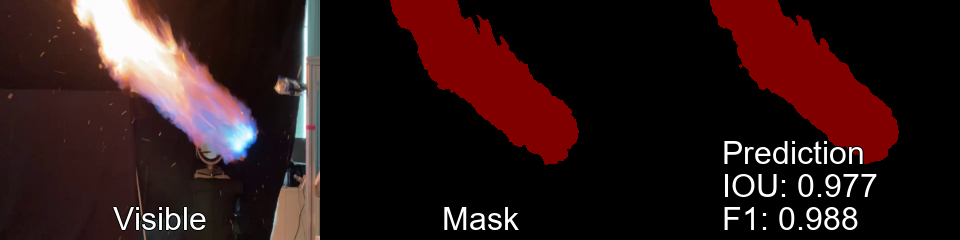

In [16]:
example_test = Image.open('Test_jetfire/Img1.png')
example_test

## Val

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)
IOU_lst = []
F1_lst = []
best_IOU = 0
best_F1 = 0
worst_IOU = 100
worst_F1 = 100
i = 0
unet_model.eval()
for imgs_val, masks_val in val_loader:
    for j in range(len(imgs_val)):
        imgs_val = imgs_val.to(device, dtype = torch.float32)
        with torch.no_grad():
            prediction = unet_model(imgs_val)
            y = masks_val.to(device = device, dtype = torch.float32).squeeze(1)
        
            prediction = torch.argmax(prediction, dim = 1).float()
            prediction = prediction.cpu()
            prediction = prediction.numpy()
            prediction = label_img_to_color(prediction[j])
            prediction = Image.fromarray(prediction.astype(np.uint8), 'RGB')
        
            y = torch.argmax(y, dim = 1).float()
            y = y.cpu()
            y = y.numpy()
            y = label_img_to_color(y[j])
            y = Image.fromarray(y.astype(np.uint8), 'RGB')
        
        
            IOU = IOU_metric(prediction, y)
            F1 = F1_metric(prediction, y)
        
            IOU_lst.append(IOU)
            F1_lst.append(F1)
        
            imgs_val = imgs_val.cpu()
            img_array = imgs_val[j].permute(1,2,0).numpy()*255
            img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
        
            i+=1
            name = "Val_jetfire/Img"+str(i)+".png"
            save_img(img, y, prediction, i, IOU, F1, name)
            
            prediction.save("Validation/Result Mask/Img"+str(i)+".png")
            y.save("Validation/Ground Truth/Img"+str(i)+".png")
            img.save("Validation/Visible/Img"+str(i)+".png")
        
            if IOU > best_IOU:
                best_IOU = IOU
                save_img(img, y, prediction, i, IOU, F1, "Val_jetfire/Best_IOU.png")
            
            if F1 > best_F1:
                best_F1 = F1
                save_img(img, y, prediction, i, IOU, F1, "Val_jetfire/Best_F1.png")
        
            if IOU < worst_IOU:
                worst_IOU = IOU
                save_img(img, y, prediction, i, IOU, F1, "Val_jetfire/Worst_IOU.png")
            
            if F1 < worst_F1:
                worst_F1 = F1
                save_img(img, y, prediction, i, IOU, F1, "Val_jetfire/Worst_F1.png")

                
print("Mean IOU: " + str(np.mean(IOU_lst)))
print("Best IOU: " + str(best_IOU))
print("Worst IOU: " + str(worst_IOU))


print("Mean F1: " + str(np.mean(F1_lst)))
print("Best F1: " + str(best_F1))
print("Worst F1: " + str(worst_F1))

Mean IOU: 0.9517320361114088
Best IOU: 0.9802218654211065
Worst IOU: 0.729025641025641
Mean F1: 0.9742912498594712
Best F1: 0.9900121622615691
Worst F1: 0.843279155248094


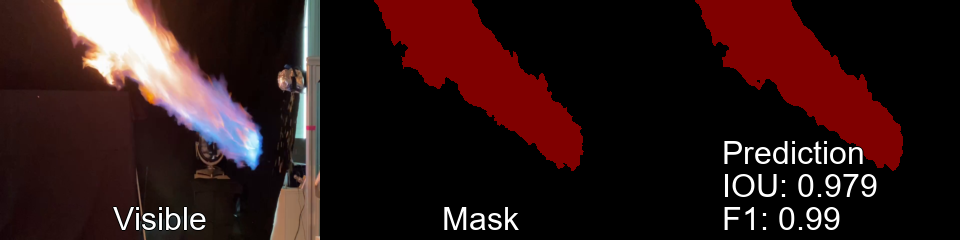

In [18]:
example_val = Image.open('Val_jetfire/Img1.png')
example_val

# Save Model

In [19]:
torch.save(unet_model, "UNET_Jetfire_Model_Checkpoint.pt")